In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import re
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/df_cleaned.csv")

In [ ]:
pip install folium

In [ ]:
import folium
from folium.plugins import HeatMap
from branca.colormap import LinearColormap

df['Log_Price'] = np.log1p(df['Price'])

# Create a base map centered on the mean coordinates
center_lat = df['Latitude'].mean()
center_lon = df['Longitude'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# Create a color map
color_map = LinearColormap(colors=['blue', 'red', 'yellow'], vmin=df['Log_Price'].min(), vmax=df['Log_Price'].max())

# Add points to the map
for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        popup=f"Price: {row['Log_Price']:,.0f}",
        color=color_map(row['Log_Price']),
        fill=True,
        fillColor=color_map(row['Log_Price']),
        fillOpacity=0.7
    ).add_to(m)

# Add color map to the map
color_map.add_to(m)
color_map.caption = 'Home Sale Price'

# Save the map
map_path = '/content/drive/MyDrive/Colab Notebooks/prices_map.html'
m.save(map_path)

In [ ]:
# Calculate Log_Price if not already done
df['Log_Price'] = np.log1p(df['Price'])

# Calculate average Log_Price for each district
district_avg_prices = df.groupby('District ID')['Log_Price'].mean().reset_index()
district_avg_prices.columns = ['District ID', 'Mean_Log_Price_District']

# Merge this back to the original dataframe
df = df.merge(district_avg_prices, on='District ID', how='left')

In [ ]:
m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# Create a color map based on district average prices
color_map = LinearColormap(colors=['blue', 'red', 'yellow'],
                           vmin=df['Mean_Log_Price_District'].min(),
                           vmax=df['Mean_Log_Price_District'].max())

# Add points to the map
for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        popup=f"District ID: {row['District ID']}<br>District Avg Log Price: {row['Mean_Log_Price_District']:.2f}<br>Actual Log Price: {row['Log_Price']:.2f}",
        color=color_map(row['Mean_Log_Price_District']),
        fill=True,
        fillColor=color_map(row['Mean_Log_Price_District']),
        fillOpacity=0.7
    ).add_to(m)

# Add color map to the map
color_map.add_to(m)
color_map.caption = 'Average District Home Sale Price (Log Scale)'

# Save the map
map_path = '/content/drive/MyDrive/Colab Notebooks/district_prices_map.html'
m.save(map_path)

print(f"Map has been saved to {map_path}")

Map has been saved to /content/drive/MyDrive/Colab Notebooks/district_prices_map.html


Застосуємо кластеризацію

In [ ]:
# get Price per Square Meter and apply log transformation

df['Log_Price_per_sqm'] = np.log1p(df['Price per sqm'])

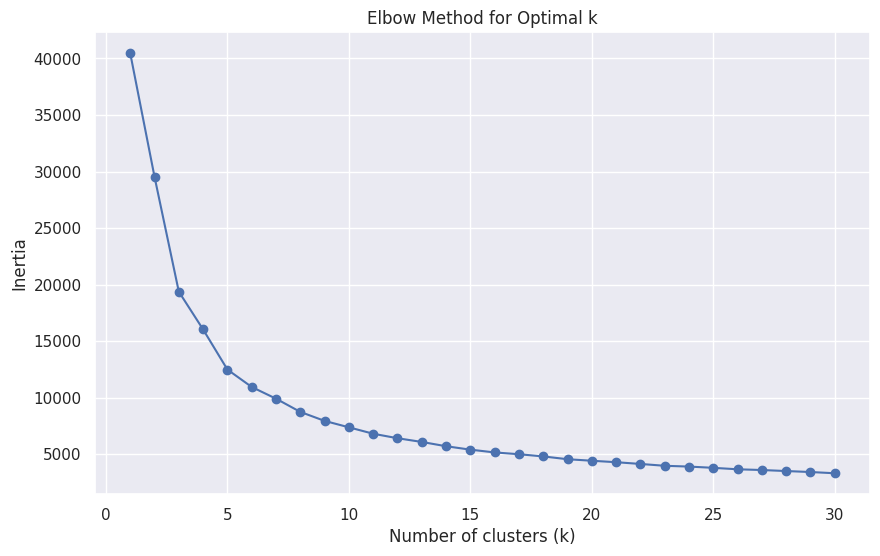

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select features for clustering
features = ['Latitude', 'Longitude', 'Log_Price_per_sqm']

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# Perform elbow method
inertias = []
max_clusters = 30

for k in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters+1), inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [ ]:
# Choose the optimal number of clusters based on the elbow method
n_clusters = 15  # Replace this with the number you determined from the elbow plot

# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# Create a map
m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=11)

# Create a color map for clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        popup=f"Cluster: {row['Cluster']}<br>Log Price per sqm: {row['Log_Price_per_sqm']:.2f}",
        color=colors[row['Cluster'] % len(colors)],
        fill=True,
        fillColor=colors[row['Cluster'] % len(colors)],
        fillOpacity=0.7
    ).add_to(m)

# Save the map
m.save('/content/drive/MyDrive/Colab Notebooks/clustered_map_price_per_sqm.html')

# Analyze clusters
cluster_summary = df.groupby('Cluster').agg({
    'Log_Price_per_sqm': 'mean',
    'Area_total': 'mean',
    'Rooms': 'mean',
    'Latitude': 'mean',
    'Longitude': 'mean'
}).reset_index()

print(cluster_summary)

    Cluster  Log_Price_per_sqm  Area_total     Rooms   Latitude  Longitude
0         0          11.300488   60.781448  1.768966  50.477266  30.408678
1         1          10.616064   69.056985  2.291707  50.416796  30.638016
2         2          11.707468  102.348768  2.514692  50.414461  30.539909
3         3          10.996388   75.658855  2.278381  50.448845  30.473360
4         4          10.596333   58.100786  2.064920  50.505073  30.607627
5         5          11.192636   60.443131  1.732017  50.378225  30.472200
6         6          11.033987   63.216479  1.950688  50.456721  30.607411
7         7          11.055774   70.037371  2.047414  50.509454  30.491969
8         8          11.251438   88.318901  2.367382  50.420892  30.523056
9         9          10.716628   67.660338  2.215385  50.399337  30.486516
10       10          11.079142   65.958823  1.832117  50.404304  30.630212
11       11          11.554867   93.729649  2.444245  50.456133  30.498134
12       12          10.6

кластери виглядають дуже перемішаними і не дають кращої ідеї розподілу ніж попередня мапа. поки що для початкових експериментів кластери застосовувати я не буду, спробую додати їх в кінці якщо всі інші додаткові фічі не допоможуть.


---



---



In [ ]:
import folium
from folium.plugins import HeatMap
from branca.colormap import LinearColormap
import numpy as np

# Ensure 'Log_Price' is calculated
df['Log_Price'] = np.log1p(df['Price'])

# Calculate average Log_Price for each district
district_avg_prices = df.groupby('District ID')['Log_Price'].mean().reset_index()
district_avg_prices.columns = ['District ID', 'Mean_Log_Price_District']

# Merge this back to the original dataframe
df = df.merge(district_avg_prices, on='District ID', how='left')

# Create a base map centered on the mean coordinates, using the "stamentoner" tile for a cleaner look
center_lat = df['Latitude'].mean()
center_lon = df['Longitude'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=11, tiles="cartodbpositron")  # Change tiles to 'cartodbpositron'

# Create a color map based on district average prices
color_map = LinearColormap(colors=['blue', 'red', 'yellow'],
                           vmin=df['Mean_Log_Price_District'].min(),
                           vmax=df['Mean_Log_Price_District'].max())

# Add points to the map
for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        popup=f"District ID: {row['District ID']}<br>District Avg Log Price: {row['Mean_Log_Price_District']:.2f}<br>Actual Log Price: {row['Log_Price']:.2f}",
        color=color_map(row['Mean_Log_Price_District']),
        fill=True,
        fillColor=color_map(row['Mean_Log_Price_District']),
        fillOpacity=0.7
    ).add_to(m)

# Add color map to the map
color_map.add_to(m)
color_map.caption = 'Average District Home Sale Price (Log Scale)'

# Save the map
map_path = '/content/drive/MyDrive/Colab Notebooks/district_prices_map_pretty.html'
m.save(map_path)

print(f"Map has been saved to {map_path}")


Map has been saved to /content/drive/MyDrive/Colab Notebooks/district_prices_map_pretty.html
